### ✅ **Session 4 – Mixed Integer Linear Programming (MILP)**

### 📦 What is MILP?

A **Mixed Integer Linear Programming (MILP)** problem is like an LP, but some variables are restricted to integer values. This is very common in real-world scenarios, such as:

✔ Deciding whether to turn a machine on or off (binary decisions)
✔ Planning production in batches (integer quantities)
✔ Assigning people to shifts (countable allocations)

MILP problems are harder to solve than LPs but very powerful in modeling discrete choices.

---

## 📦 **Example Problem – Product Selection with Fixed Costs**

**Problem Statement:**
You produce products `A` and `B`. Each product has:

✔ A fixed setup cost if it’s produced at all.
✔ A variable cost per unit produced.
✔ A maximum capacity limit.

You must decide:

* Whether to produce each product at all (on/off decision).
* How much to produce within capacity.

**Goal:** Minimize total cost while meeting demand.

In [1]:
products = ['A', 'B']

setup_cost = {'A': 100, 'B': 150}
variable_cost = {'A': 20, 'B': 30}
max_capacity = {'A': 50, 'B': 60}
demand = 70

In [7]:
from pyomo.environ import Param, Set, ConcreteModel, Var, Objective, Constraint, SolverFactory, NonNegativeReals, Binary, minimize

# Create the model
model = ConcreteModel()

# Sets
model.PRODUCTS = Set(initialize=products)

# Parameters
model.setup_cost = Param(model.PRODUCTS, initialize=setup_cost)
model.variable_cost = Param(model.PRODUCTS, initialize=variable_cost)
model.max_capacity = Param(model.PRODUCTS, initialize=max_capacity)
model.demand = demand

# Variables
model.produce = Var(model.PRODUCTS, domain=NonNegativeReals)
model.is_open = Var(model.PRODUCTS, domain=Binary)

# Objective: minimize total cost
model.total_cost = Objective(expr = sum(model.setup_cost[p] * model.is_open[p] + model.variable_cost[p] * model.produce[p] for p in model.PRODUCTS), sense=minimize)

# Capacity constraints
def capacity_rule(model, p):
    return model.produce[p] <= model.max_capacity[p] * model.is_open[p]
model.capacity_constraint = Constraint(model.PRODUCTS, rule=capacity_rule)

# Demand constraint
model.demand_constraint = Constraint(expr = sum(model.produce[p] for p in model.PRODUCTS) >= model.demand)

# Solve using GLPK
solver = SolverFactory('glpk')
result = solver.solve(model, tee=True)

# Print results
print("Optimal production plan:")
for p in model.PRODUCTS:
    print(f"  Produce {p}: {model.produce[p].value} units (Open: {model.is_open[p].value})")
print("Total cost:", model.total_cost())


GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write C:\Users\desai\AppData\Local\Temp\tmpcszwz58a.glpk.raw --wglp C:\Users\desai\AppData\Local\Temp\tmp4t279qyo.glpk.glp
 --cpxlp C:\Users\desai\AppData\Local\Temp\tmp9d3s0d4w.pyomo.lp
Reading problem data from 'C:\Users\desai\AppData\Local\Temp\tmp9d3s0d4w.pyomo.lp'...
C:\Users\desai\AppData\Local\Temp\tmp9d3s0d4w.pyomo.lp:33: warning: lower bound of variable 'x2' redefined
C:\Users\desai\AppData\Local\Temp\tmp9d3s0d4w.pyomo.lp:33: warning: upper bound of variable 'x2' redefined
3 rows, 4 columns, 6 non-zeros
2 integer variables, all of which are binary
35 lines were read
Writing problem data to 'C:\Users\desai\AppData\Local\Temp\tmp4t279qyo.glpk.glp'...
25 lines were written
GLPK Integer Optimizer, v4.65
3 rows, 4 columns, 6 non-zeros
2 integer variables, all of which are binary
Preprocessing...
3 rows, 2 columns, 4 non-zeros
0 integer variables, none of which are binary
Scaling...
 A: min|aij| =  1.00

Optimal production plan:
  A: 50.0 units (Open: 1.0)
  B: 20.0 units (Open: 1.0)
Total cost: 1850.0


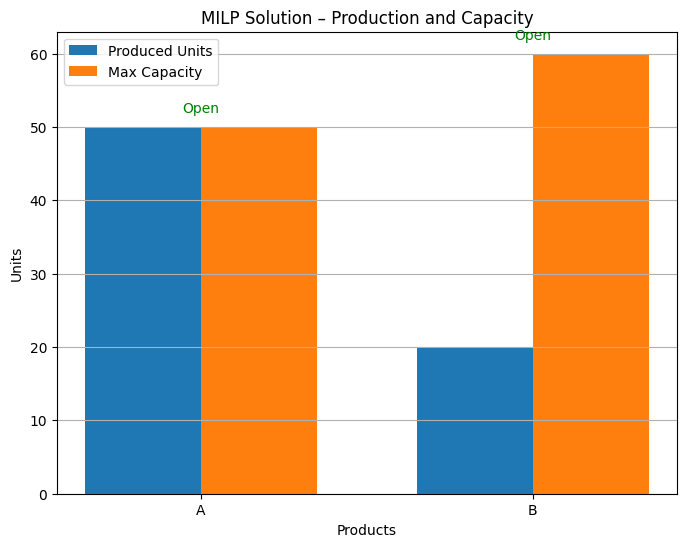

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from pyomo.environ import ConcreteModel, Var, Objective, Constraint, SolverFactory, NonNegativeReals, Binary, minimize, Set, Param

# Define data
products = ['A', 'B']
setup_cost = {'A': 100, 'B': 150}
variable_cost = {'A': 20, 'B': 30}
max_capacity = {'A': 50, 'B': 60}
demand = 70

# Create model
model = ConcreteModel()
model.PRODUCTS = Set(initialize=products)
model.setup_cost = Param(model.PRODUCTS, initialize=setup_cost)
model.variable_cost = Param(model.PRODUCTS, initialize=variable_cost)
model.max_capacity = Param(model.PRODUCTS, initialize=max_capacity)
model.demand = demand

# Variables
model.produce = Var(model.PRODUCTS, domain=NonNegativeReals)
model.is_open = Var(model.PRODUCTS, domain=Binary)

# Objective
model.total_cost = Objective(expr = sum(model.setup_cost[p] * model.is_open[p] + model.variable_cost[p] * model.produce[p] for p in model.PRODUCTS), sense=minimize)

# Constraints
def capacity_rule(model, p):
    return model.produce[p] <= model.max_capacity[p] * model.is_open[p]
model.capacity_constraint = Constraint(model.PRODUCTS, rule=capacity_rule)

model.demand_constraint = Constraint(expr = sum(model.produce[p] for p in model.PRODUCTS) >= model.demand)

# Solve
solver = SolverFactory('glpk')
result = solver.solve(model, tee=False)

# Print results
print("Optimal production plan:")
for p in model.PRODUCTS:
    print(f"  {p}: {model.produce[p].value} units (Open: {model.is_open[p].value})")
print("Total cost:", model.total_cost())

# Plotting
prod_values = [model.produce[p].value for p in products]
cap_values = [max_capacity[p] for p in products]
open_values = [model.is_open[p].value for p in products]

x = np.arange(len(products))

width = 0.35

fig, ax = plt.subplots(figsize=(8,6))

# Production vs Capacity bars
rects1 = ax.bar(x - width/2, prod_values, width, label='Produced Units')
rects2 = ax.bar(x + width/2, cap_values, width, label='Max Capacity')

# Annotate bars with "Open" or "Closed"
for i, open_flag in enumerate(open_values):
    status = "Open" if open_flag >= 0.5 else "Closed"
    ax.text(x[i], cap_values[i] + 2, status, ha='center', fontsize=10, color='green' if open_flag >= 0.5 else 'red')

ax.set_xlabel('Products')
ax.set_ylabel('Units')
ax.set_title('MILP Solution – Production and Capacity')
ax.set_xticks(x)
ax.set_xticklabels(products)
ax.legend()
ax.grid(axis='y')

plt.show()
